## Introduction/Method
I'm going to use an autoencoder to reduce our input dimensions from nine data fields to five. From here, I'll use PCA and tSNE to further break down the dimensions, and see if we can visualize clusters that naturally form  from the associations between the data fields. The general workflow of this project will look like this: \
$\textrm{Input Data} \rightarrow \textrm{Autoencoder} \rightarrow \textrm{Retrieve results from the first round of dimensional reduction}\rightarrow \textrm{PCA/tSNE/Visualization}$

In [1]:
import numpy as np
import pandas as pd

In [2]:
country_data_full = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')
country_data_full.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# We're going to use a copy of the original data as input to the autoencoder
data_input = country_data_full.drop('country',axis=1)

In [4]:
# normalizes data so the weights and biases of the autoencoder aren't off the charts
for col in data_input.columns.to_list():
    col_mean = data_input[col].mean()
    data_input[col] = data_input[col]/col_mean

In [5]:
data_input.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,2.356934,0.243256,1.112140,0.957556,0.093907,1.213082,0.796534,1.974244,0.042656
1,0.433759,0.681116,0.961018,1.036464,0.579188,0.576985,1.081415,0.559708,0.315485
2,0.713351,0.934103,0.611824,0.669649,0.752420,2.068921,1.084250,0.980338,0.344025
3,3.109480,1.515484,0.418153,0.914903,0.344130,2.878499,0.851809,2.089578,0.272289
4,0.269140,1.106814,0.884724,1.256126,1.114048,0.185046,1.088502,0.722533,0.941056


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [7]:
# Building a simple autoencoder to cluster countries

# Encoder
encoder = Sequential()
encoder.add(Input(shape=(9,)))
encoder.add(Dense(30,activation='relu'))
encoder.add(Dense(20,activation='relu'))
encoder.add(Dense(15,activation='relu'))
encoder.add(Dense(10,activation='relu'))
encoder.add(Dense(5,activation='relu'))

# Decoder
decoder = Sequential()
decoder.add(Dense(10,activation='relu'))
decoder.add(Dense(15,activation='relu'))
decoder.add(Dense(20,activation='relu'))
decoder.add(Dense(30,activation='relu'))
decoder.add(Dense(9,activation='relu'))

In [8]:
autoencoder = Sequential([encoder,decoder])

In [9]:
autoencoder.compile(loss='mse',
                   optimizer='Adam',
                   metrics = ['accuracy'])
autoencoder_res = autoencoder.fit(data_input,data_input,
               epochs = 1500,
               verbose = False)

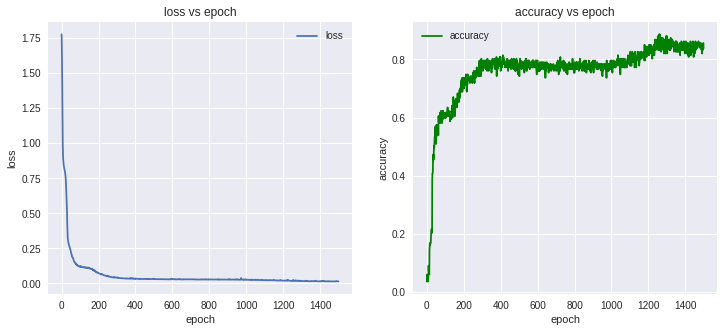

In [10]:
metrics_fig = plt.figure(figsize=(12,5))

loss_ax = metrics_fig.add_subplot(1,2,1)
loss_ax.plot(autoencoder_res.history['loss'],label='loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_title('loss vs epoch')
loss_ax.legend()

acc_ax = metrics_fig.add_subplot(1,2,2)
acc_ax.plot(autoencoder_res.history['accuracy'],label='accuracy',color='green')
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.set_title('accuracy vs epoch')
acc_ax.legend()

plt.show()

The loss seems to have converged after 1500 epochs, so we call it there. Now, we extract the encoded form of the input data.

In [11]:
all_layers = autoencoder.trainable_variables
print('number of total tensors = ', len(all_layers))
# Tensorflow puts intermediate tensors to link layers, so since we want layer 5 (clustering layer), we check index 9

number of total tensors =  20


In [12]:
print('length of the ninth tensor = ',len(all_layers[9].numpy()))
# This means all_layers[9].numpy() holds our clustering dimension parameters

length of the ninth tensor =  5


In [13]:
d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
dim_dict = {'d1':d1,
           'd2':d2,
           'd3':d3,
           'd4':d4,
           'd5':d5}
for i in range(len(data_input)):
    prediction = pd.Series(encoder.predict(data_input.iloc[i].values.reshape(-1,9))[0])
    for j in range(len(prediction)):
        dim_dict['d'+str(j+1)].append(prediction[j])
        

In [14]:
clustered_dims = pd.DataFrame(dim_dict)

In [15]:
clustered_dims.head() 
# Keep in mind the index of the row corresponds directly to the index of country in the original table

,d1,d2,d3,d4,d5
0,3.229804,4.843643,0.966450,3.484295,0.0
1,3.452004,2.704811,0.384390,1.232647,0.0
2,5.331381,4.905353,0.355019,3.183087,0.0
3,6.862045,9.214403,0.612301,5.271892,0.0
4,4.612243,3.374845,0.234514,0.972308,0.0


Now, we partition the countries by the quartile they fall in for each data field.

In [16]:
quant_columns = ['child_mort','exports','health','imports','income','inflation','life_expec',
                'total_fer','gdpp']
for col in quant_columns:
    percentile_scores = np.percentile(country_data_full[col].values,[25,50,75])
    raw_vals = country_data_full[col].values
    quartile = []
    for val in raw_vals:
        if val<percentile_scores[0]:
            quartile.append(1)
        elif val<percentile_scores[1]:
            quartile.append(2)
        elif val<percentile_scores[2]:
            quartile.append(3)
        else:
            quartile.append(4)
    quartile_ser = pd.Series(quartile)
    country_data_full[col+'_quartile'] = quartile_ser

In [17]:
quartile_cols = [col+'_quartile' for col in quant_columns]

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d

In [19]:
# Grouping dimensions together by "country"
dims_zipped = []
for (dim1,dim2,dim3,dim4,dim5) in zip(d1,d2,d3,d4,d5):
    dims_zipped.append((dim1,dim2,dim3,dim4,dim5))

In [20]:
# Performing PCA and taking the first three components
pca = PCA(n_components=3)
pca_res = pca.fit_transform(dims_zipped)

In [21]:
# Storing the first three components in a DataFrame
pca_df = pd.DataFrame(columns=['pca1','pca2','pca3'])
pca_df['pca1'] = pca_res[:,0]
pca_df['pca2'] = pca_res[:,1]
pca_df['pca3'] = pca_res[:,2]

Below, we have the plots for the health-based metrics for countries. In each of these scatterplots, a point represents a country, and its color is the value of the metric denoted by the graph title. The axes are dimensionless; rather, they are an amalgamation of components of the dimensionally reduced data we started with. \
We can see that component 1 seems to correspond strongly with the overall level of health/physical well-being a country has. The crescent shaped cluster is an interesting emergent feature of the dimensionality reduction we put the data through. \
If we look closely, we see that the left curve of the crescent is made up of two distinct tiers of metric evaluation (country wise). I have denoted this on the health graph.

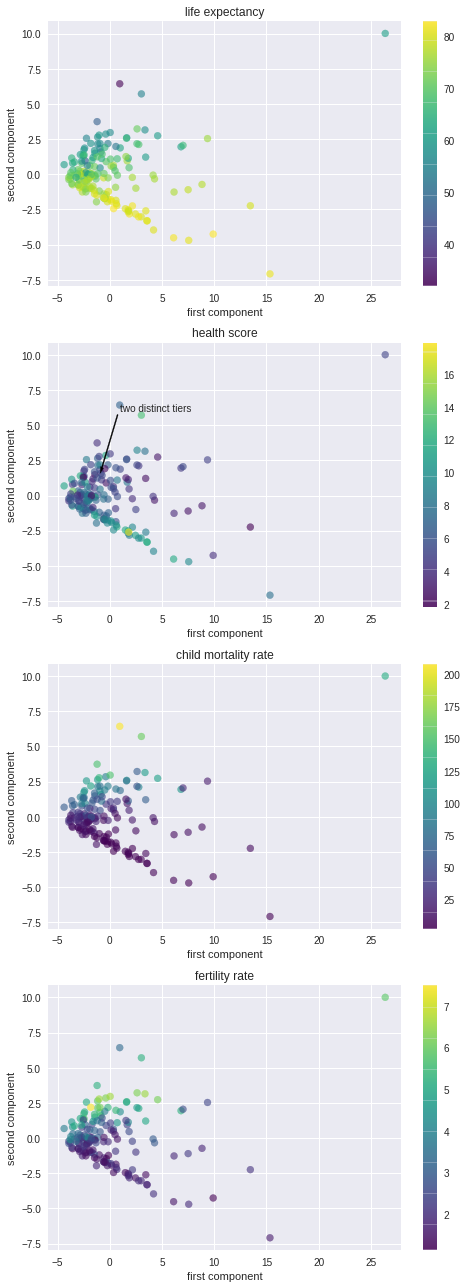

In [22]:
pca_fig1 = plt.figure(figsize=(7,18))

ax1 = pca_fig1.add_subplot(4,1,1)
a1 = ax1.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['life_expec'],
            cmap='viridis',
            alpha=0.6)
ax1.set_xlabel('first component')
ax1.set_ylabel('second component')
ax1.set_title('life expectancy')
pca_fig1.colorbar(a1)

ax2 = pca_fig1.add_subplot(4,1,2)
a2 = ax2.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['health'],
            cmap='viridis',
            alpha=0.6)
ax2.set_xlabel('first component')
ax2.set_ylabel('second component')
ax2.set_title('health score')
plt.text(1,6,'two distinct tiers')
plt.arrow(0.75,5.75,-1.5,-3.75,
         width=0.1,
         color='black')
pca_fig1.colorbar(a2)

ax3 = pca_fig1.add_subplot(4,1,3)
a3 = ax3.scatter(pca_df['pca1'],pca_df['pca2'],
             c=country_data_full['child_mort'],
             cmap='viridis',
             alpha=0.6)
ax3.set_xlabel('first component')
ax3.set_ylabel('second component')
ax3.set_title('child mortality rate')
pca_fig1.colorbar(a3)

ax4 = pca_fig1.add_subplot(4,1,4)
a4 = ax4.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['total_fer'],
            cmap='viridis',
            alpha=0.6)
ax4.set_xlabel('first component')
ax4.set_ylabel('second component')
ax4.set_title('fertility rate')
pca_fig1.colorbar(a4)

plt.tight_layout()
plt.show()

Here, we have the economic metrics from our original data represented as color values. We see a strong correlation once again with the first component and the economic health of the country. We can also see the massive wealth inequity between countries on a global scale, made apparent by the few countries above an income of 50000 (assumed)USD/year. 

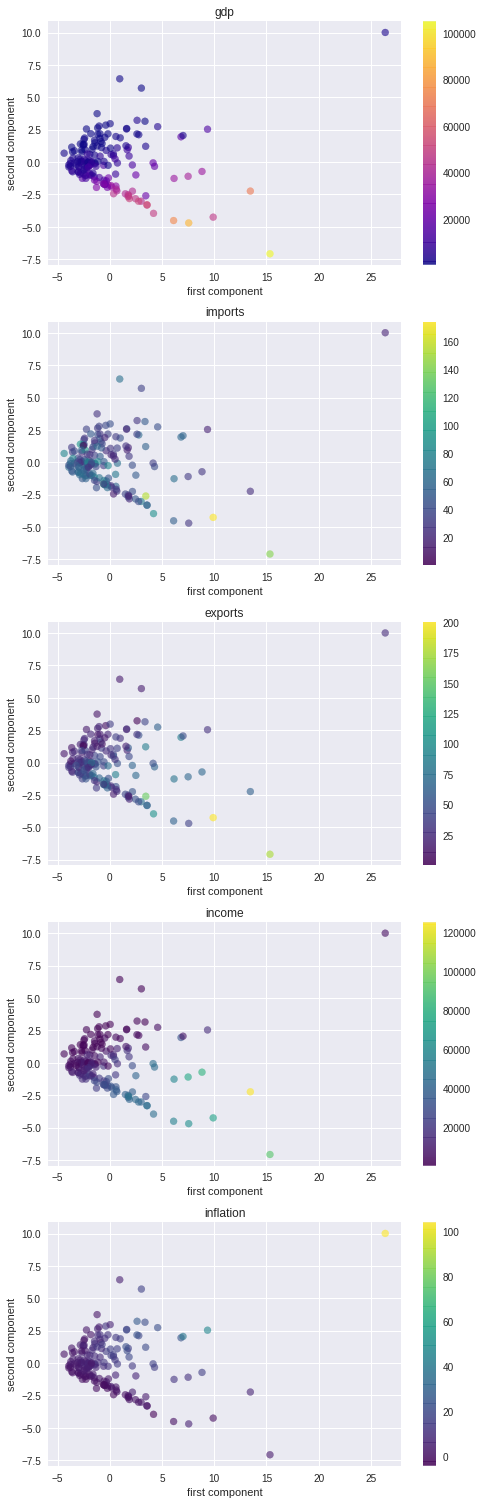

In [23]:
pca_fig2 = plt.figure(figsize=(7,21))

ax11 = pca_fig2.add_subplot(5,1,1)
a11 = ax11.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['gdpp'],
            cmap='plasma', # note that this colormap is different for distinguishable stratification in the crescent.
            alpha=0.6)
ax11.set_xlabel('first component')
ax11.set_ylabel('second component')
ax11.set_title('gdp')
pca_fig2.colorbar(a11)

ax21 = pca_fig2.add_subplot(5,1,2)
a21 = ax21.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['imports'],
            cmap='viridis',
            alpha=0.6)
ax21.set_xlabel('first component')
ax21.set_ylabel('second component')
ax21.set_title('imports')
pca_fig2.colorbar(a21)

ax31 = pca_fig2.add_subplot(5,1,3)
a31 = ax31.scatter(pca_df['pca1'],pca_df['pca2'],
             c=country_data_full['exports'],
             cmap='viridis',
             alpha=0.6)
ax31.set_xlabel('first component')
ax31.set_ylabel('second component')
ax31.set_title('exports')
pca_fig2.colorbar(a31)

ax41 = pca_fig2.add_subplot(5,1,4)
a41 = ax41.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['income'],
            cmap='viridis',
            alpha=0.6)
ax41.set_xlabel('first component')
ax41.set_ylabel('second component')
ax41.set_title('income')
pca_fig2.colorbar(a41)

ax51 = pca_fig2.add_subplot(5,1,5)
a51 = ax51.scatter(pca_df['pca1'],pca_df['pca2'],
            c=country_data_full['inflation'],
            cmap='viridis',
            alpha=0.6)
ax51.set_xlabel('first component')
ax51.set_ylabel('second component')
ax51.set_title('inflation')
pca_fig2.colorbar(a51)

plt.tight_layout()
plt.show()

In [24]:
from PIL import Image
import glob

In [25]:
# Now we perform tSNE to see if we can get an alternate visualization. 
# Note: I played around with the perplexity parameter a bit in order to get some decent groupings!
tsne2 = TSNE(n_components=2,perplexity=40) 
tsne3 = TSNE(n_components=3,perplexity=25)
embedded2 = tsne2.fit_transform(dims_zipped)
embedded3 = tsne3.fit_transform(dims_zipped)

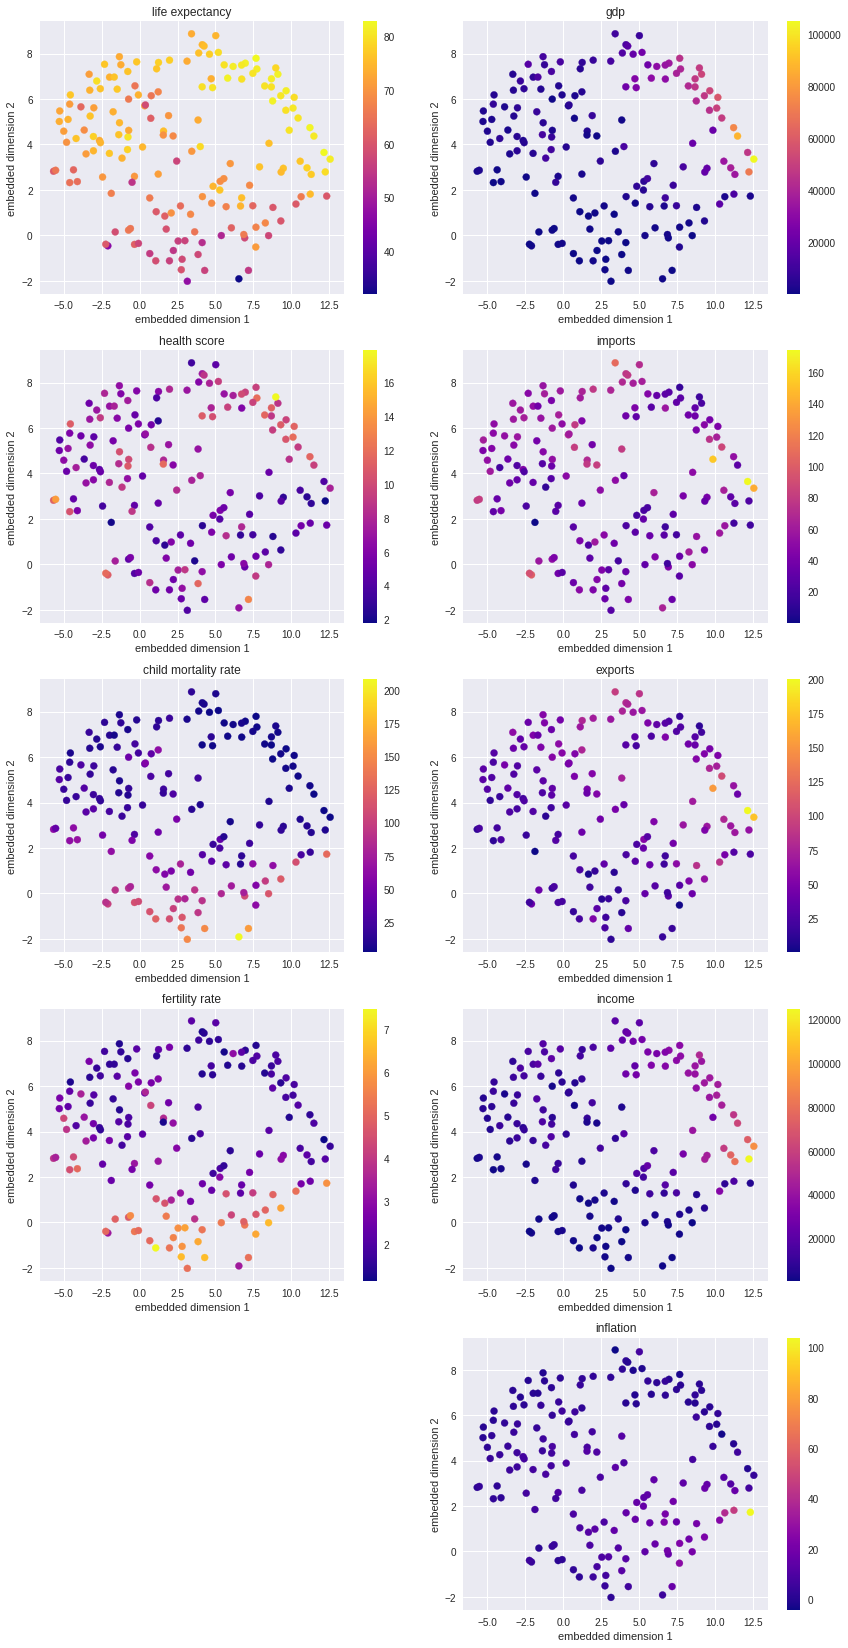

In [26]:
tsne_2dfigs = plt.figure(figsize=(12,23))

ax2d1 = tsne_2dfigs.add_subplot(5,2,1)
tsne21 = ax2d1.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['life_expec'],
            cmap='plasma')
ax2d1.set_xlabel('embedded dimension 1')
ax2d1.set_ylabel('embedded dimension 2')
ax2d1.set_title('life expectancy')
plt.colorbar(tsne21)

ax2d2 = tsne_2dfigs.add_subplot(5,2,2)
tsne22 = ax2d2.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['gdpp'],
            cmap='plasma')
ax2d2.set_xlabel('embedded dimension 1')
ax2d2.set_ylabel('embedded dimension 2')
ax2d2.set_title('gdp')
plt.colorbar(tsne22)

ax2d3 = tsne_2dfigs.add_subplot(5,2,3)
tsne23 = ax2d3.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['health'],
            cmap='plasma')
ax2d3.set_xlabel('embedded dimension 1')
ax2d3.set_ylabel('embedded dimension 2')
ax2d3.set_title('health score')
plt.colorbar(tsne23)

ax2d4 = tsne_2dfigs.add_subplot(5,2,4)
tsne24 = ax2d4.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['imports'],
            cmap='plasma')
ax2d4.set_xlabel('embedded dimension 1')
ax2d4.set_ylabel('embedded dimension 2')
ax2d4.set_title('imports')
plt.colorbar(tsne24)

ax2d5 = tsne_2dfigs.add_subplot(5,2,5)
tsne25 = ax2d5.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['child_mort'],
            cmap='plasma')
ax2d5.set_xlabel('embedded dimension 1')
ax2d5.set_ylabel('embedded dimension 2')
ax2d5.set_title('child mortality rate')
plt.colorbar(tsne25)

ax2d6 = tsne_2dfigs.add_subplot(5,2,6)
tsne26 = ax2d6.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['exports'],
            cmap='plasma')
ax2d6.set_xlabel('embedded dimension 1')
ax2d6.set_ylabel('embedded dimension 2')
ax2d6.set_title('exports')
plt.colorbar(tsne26)

ax2d7 = tsne_2dfigs.add_subplot(5,2,7)
tsne27 = ax2d7.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['total_fer'],
            cmap='plasma')
ax2d7.set_xlabel('embedded dimension 1')
ax2d7.set_ylabel('embedded dimension 2')
ax2d7.set_title('fertility rate')
plt.colorbar(tsne27)

ax2d8 = tsne_2dfigs.add_subplot(5,2,8)
tsne28 = ax2d8.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['income'],
            cmap='plasma')
ax2d8.set_xlabel('embedded dimension 1')
ax2d8.set_ylabel('embedded dimension 2')
ax2d8.set_title('income')
plt.colorbar(tsne28)

ax2d10 = tsne_2dfigs.add_subplot(5,2,10)
tsne210 = ax2d10.scatter(embedded2[:,0],embedded2[:,1],
            c = country_data_full['inflation'],
            cmap='plasma')
ax2d10.set_xlabel('embedded dimension 1')
ax2d10.set_ylabel('embedded dimension 2')
ax2d10.set_title('inflation')
plt.colorbar(tsne210)


plt.tight_layout()
plt.show()

In [27]:
tsne3d_df = pd.DataFrame(columns=['embedded dimension 1','embedded dimension 2','embedded dimension 3'])
for i in range(len(tsne3d_df.columns)):
    tsne3d_df[tsne3d_df.columns.to_list()[i]] = embedded3[:,i]

In [28]:
import plotly.express as px
df = tsne3d_df
tsne3d_fig = px.scatter_3d(df,
                          x = 'embedded dimension 1', y = 'embedded dimension 2', z = 'embedded dimension 3',
                          color = country_data_full['income'])
tsne3d_fig.show()

This plot shows us that it's harder to draw concrete clusters from applying tSNE to reduce to three embedded dimensions, while plotting continuous values of metrics. Running the cell will start an interactive session! We now try and plot the quartile in which the country falls in with respect to the metric.

In [29]:
tsne3d_quart = px.scatter_3d(df,
                          x = 'embedded dimension 1', y = 'embedded dimension 2', z = 'embedded dimension 3',
                          color = country_data_full['income_quartile'])
tsne3d_quart.show()

We see that the first and fourth quartiles are separated pretty well, but the points are a bit too interspersed for us to draw more concrete clusters.

## Conclusions
After using an autoencoder to get a lower dimensional representation of our nine-dimensional data, we used PCA and tSNE to visualize clusters and patterns among clusters in regards to the metrics we had for each country. We saw a crescent shape arise in our two dimensional PCA, where the left half seemed to encompass underdeveloped and developing countries. The right part of the crescent was home to what we would colloquially term the developed world. We can see the associations that this measure of development has on health and economic development, as most of the countries on the right half of the crescent were in the upper tiers of those metrics, while those on the left were in the lower tiers. This really paints a picture about development and how investing in your own community has tangible benefits on the individual level as well on the scale of the nation as a whole.